In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.utils import to_categorical

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE=654321
TEST_SIZE=0.3

In [2]:
def feature_importance(importances, feature_names, top_n=20):
    """
    Функция для построения графика feature importance.

    Параметры:
    - importances: массив важности признаков
    - feature_names: массив имен признаков
    - top_n: количество первых признаков, которые нужно отобразить (по умолчанию 20)
    """
    # Создаем DataFrame для удобства отображения
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    
    # Отсортируем по важности
    feature_importance_df = feature_importance_df.sort_values(by='Importance')
    
    # Отобразим только первые top_n признаков
    feature_importance_df_top_n = feature_importance_df[-top_n:]
    
    # Построим график важности фичей
    plt.figure(figsize=(10, 10))
    plt.barh(feature_importance_df_top_n['Feature'], feature_importance_df_top_n['Importance'])
    plt.xlabel('Важность признака')
    plt.title('Влияние признаков на работу модели (Топ {})'.format(top_n), loc='left')
    plt.show()

In [3]:
def plot_distribution(data, column, ax, title=None):
    """
    Функция строит гистограмму распределения данных для указанного столбца в датафрейме.

    Параметры:
        data (pandas.DataFrame): Датафрейм, содержащий данные.
        column (str): Имя столбца, для которого требуется построить гистограмму распределения.
        title (str, по умолчанию None): Название графика. Если не указано, используется автоматически сформированное название.
        ax (matplotlib.axes._subplots.AxesSubplot): Ось для рисования графика.

    Возвращаемое значение:
        None
        Выводит на экран графики для каждого столбца.
    """
    sns.histplot(data[column].dropna(), kde=True, ax=ax)
    ax.set_title(f"Распределениe данных столбца '{column}'" if title is None else title)
    ax.set_xlabel(column)
    ax.set_ylabel(f"Значения '{column}'")
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.tick_params(axis='x', rotation=45)

In [4]:
def divide_data_to_nums_and_cat_features(df):
  """
  Функция возвращает списки числовых и категориальных признаков, а также числовой и категориальный датасеты
  """
  numeric_cols = df.select_dtypes(exclude=['object']).columns
  categoric_cols = [column for column in df.columns if column not in numeric_cols]
  df_numeric = df[numeric_cols]
  df_categoric = df[categoric_cols]
  return numeric_cols, categoric_cols, df_numeric, df_categoric

In [5]:
def plot_all_distributions(df, num_columns=3):
    """
    Функция строит гистограммы распределения данных для всех числовых признаков в датафрейме.

    Параметры:
        df (pandas.DataFrame): Датафрейм, содержащий данные.
        num_columns (int): Количество столбцов в сетке графиков.

    Возвращаемое значение:
        None
        Выводит на экран графики для каждого числового столбца.
    """

    numeric_columns = df.select_dtypes(exclude=['object']).columns

    num_plots = len(numeric_columns)
    num_rows = (num_plots + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 7, num_rows * 5))

    axes = axes.flatten()

    for i, column in enumerate(numeric_columns):
        plot_distribution(df, column, axes[i])

    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    plt.show()

In [6]:
def boxplot_distribution(data, column, ax, title=None):
    """
    Функция строит боксплот распределения данных для указанного столбца в датафрейме.

    Параметры:
        data (pandas.DataFrame): Датафрейм, содержащий данные.
        column (str): Имя столбца, для которого требуется построить гистограмму распределения.
        title (str, по умолчанию None): Название графика. Если не указано, используется автоматически сформированное название.
        ax (matplotlib.axes._subplots.AxesSubplot): Ось для рисования графика.

    Возвращаемое значение:
        None
        Выводит на экран графики для каждого столбца.
    """
    sns.boxplot(data[column].dropna(), ax=ax)
    ax.set_title(f"Распределениe данных столбца '{column}'" if title is None else title)
    ax.set_xlabel(column)
    ax.set_ylabel(f"Значения '{column}'")
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.tick_params(axis='x', rotation=45)

In [7]:
def boxplot_all_distributions(df, num_columns=3):
    """
    Функция строит боксплот распределения данных для всех числовых признаков в датафрейме.

    Параметры:
        df (pandas.DataFrame): Датафрейм, содержащий данные.
        num_columns (int): Количество столбцов в сетке графиков.

    Возвращаемое значение:
        None
        Выводит на экран графики для каждого числового столбца.
    """

    numeric_columns = df.select_dtypes(exclude=['object']).columns

    num_plots = len(numeric_columns)
    num_rows = (num_plots + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 7, num_rows * 5))

    axes = axes.flatten()

    for i, column in enumerate(numeric_columns):
        boxplot_distribution(df, column, axes[i])

    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    plt.show()

In [8]:
# Установим отображение всех столбцов при выводе датафрейма.
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [9]:
df = pd.read_excel(r'C:\Users\ZeleninAD\Desktop\datasets/Base_TOF.xlsx', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 296 entries, 1 to 1
Data columns (total 40 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   23           296 non-null    int64  
 1   24           296 non-null    float64
 2   25           296 non-null    int64  
 3   26           296 non-null    float64
 4   27           7 non-null      object 
 5   28           296 non-null    int64  
 6   29           292 non-null    float64
 7   30           296 non-null    int64  
 8   31           296 non-null    float64
 9   32           294 non-null    float64
 10  33           284 non-null    float64
 11  34           283 non-null    float64
 12  35           295 non-null    float64
 13  36           294 non-null    float64
 14  37           296 non-null    float64
 15  38           296 non-null    float64
 16  39           63 non-null     object 
 17  40           291 non-null    float64
 18  41           296 non-null    float64
 19  42           17

In [10]:
df = df.iloc[:, :23]
df.reset_index(level=0, inplace=True) 

In [11]:
df.columns = [ 'gender', 'age', 'weight', 'height', 'bca', 'sopvps', 'gestational_age', 'o2_capillary',
               'aaaa', 'bbbb', 'kdrlj', 'ksrlj', 'kdolj', 'pla', 'lpa', 'trunc_la', 'fc_la', 'sashes_kl_la',
               'pressure_gradient', 'dmjpmm', 'pressure_pj', 'lai', 'avnao', 'surgery']
df.head()

,gender,age,weight,height,bca,sopvps,gestational_age,o2_capillary,aaaa,bbbb,kdrlj,ksrlj,kdolj,pla,lpa,trunc_la,fc_la,sashes_kl_la,pressure_gradient,dmjpmm,pressure_pj,lai,avnao,surgery
0,1,122,3.77,57,0.25,NaN,30,70.0,2,71.3,1.6,1.0,7.2,5.9,5.4,7.5,6.7,створки ограничены в подвижности,70.0,8.2,NaN,NaN,NaN,3
1,2,123,5.40,58,0.30,NaN,37,93.6,2,72.6,1.8,1.1,9.7,5.0,6.0,8.0,8.0,"створки уплотнены,удлинены,сращены",85.0,9.0,NaN,NaN,NaN,1
2,1,164,3.90,57,0.25,"ди джорджи?блд, �",30,66.0,2,71.3,1.6,1.0,7.2,4.0,5.4,7.5,6.7,створки ограничены в подвижности,126.0,8.2,NaN,NaN,NaN,3
3,2,123,5.40,58,0.30,NaN,37,93.6,2,72.6,1.8,1.1,9.7,5.0,6.0,8.0,8.0,"створки уплотнены, удлинены, сращены",85.0,9.0,NaN,NaN,NaN,1
4,1,63,3.85,52,0.24,NaN,40,66.7,2,66.0,1.5,1.0,6.1,3.5,3.5,6.0,5.0,"створки удлинены, сращены, отв 3 мм",80.0,10.0,NaN,NaN,NaN,3


In [12]:
# проверим данные на наличие явных дубликатов
df[df.duplicated()]

,gender,age,weight,height,bca,sopvps,gestational_age,o2_capillary,aaaa,bbbb,kdrlj,ksrlj,kdolj,pla,lpa,trunc_la,fc_la,sashes_kl_la,pressure_gradient,dmjpmm,pressure_pj,lai,avnao,surgery
181,2,15,3.30,52,0.22,NaN,39,87.8,2,66.0,1.5,1.0,6.1,4.5,5.0,7.0,6.0,NaN,70.0,9.0,96.0,109.74,1.39,4
182,1,138,7.67,63,0.37,NaN,39,92.0,2,79.3,2.2,1.2,16.2,5.0,5.0,7.0,7.0,NaN,102.0,10.0,96.0,276.66,1.34,1
183,2,172,5.80,62,0.32,NaN,38,90.0,2,79.3,2.2,1.2,16.2,6.0,5.0,7.0,5.0,NaN,95.0,11.0,85.0,334.21,2.65,1
184,2,618,9.20,73,0.44,NaN,40,80.0,2,70.0,2.6,1.3,21.1,6.0,6.0,11.0,8.0,NaN,75.0,15.0,85.0,322.19,2.07,1
185,1,244,7.90,66,0.38,NaN,39,85.0,2,70.0,2.1,1.0,13.5,7.0,7.0,8.0,6.0,NaN,92.0,12.0,90.0,754.40,1.81,1
186,1,166,6.20,64,0.33,NaN,38,80.0,1,68.3,1.7,1.1,8.4,7.0,7.0,6.0,7.0,NaN,101.0,11.0,90.0,257.16,1.61,3
187,1,153,7.44,62,0.36,NaN,39,69.7,2,73.6,2.0,1.2,12.7,8.0,8.0,12.0,6.0,NaN,80.0,12.0,NaN,NaN,NaN,1
204,1,82,5.50,62,0.31,NaN,40,89.1,2,67.9,2.5,1.6,22.3,10.0,10.0,14.0,11.0,"створки уплотнены, умеренно сращены",35.0,12.0,NaN,NaN,NaN,1


In [13]:
df = df.drop_duplicates()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 288 entries, 0 to 295
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             288 non-null    int64  
 1   age                288 non-null    int64  
 2   weight             288 non-null    float64
 3   height             288 non-null    int64  
 4   bca                288 non-null    float64
 5   sopvps             7 non-null      object 
 6   gestational_age    288 non-null    int64  
 7   o2_capillary       284 non-null    float64
 8   aaaa               288 non-null    int64  
 9   bbbb               288 non-null    float64
 10  kdrlj              286 non-null    float64
 11  ksrlj              276 non-null    float64
 12  kdolj              275 non-null    float64
 13  pla                287 non-null    float64
 14  lpa                286 non-null    float64
 15  trunc_la           288 non-null    float64
 16  fc_la              288 non-null

In [15]:
df['sopvps'].value_counts()

sopvps
пп цнс               2
ди джорджи?блд, �    1
миелодиспласти�      1
рахит                1
с-м дауна            1
с-м ди джорджи       1
Name: count, dtype: int64

In [16]:
# очистим текстовые признаки от лишних символов, в пропуски поставим заглушки 
df['sopvps'] = df['sopvps'].replace({
    'ди джорджи?блд, �': 'с-м Ди Джорджи',
    'миелодиспласти�': 'Миелодиспластический с-м',
    'с-м ди джорджи': 'с-м Ди Джорджи'
})

df.fillna({'sopvps': 'не выявлено'}, inplace=True)

df['sopvps'].value_counts(dropna=False)

sopvps
не выявлено                 281
с-м Ди Джорджи                2
пп цнс                        2
Миелодиспластический с-м      1
рахит                         1
с-м дауна                     1
Name: count, dtype: int64

In [17]:
df.fillna({'sashes_kl_la': 'нет данных'}, inplace=True)
df['sashes_kl_la'].value_counts(dropna=False)

sashes_kl_la
нет данных                                         226
створки уплотнены, сращены                           9
створки ограничены в подвижности                     5
створки уплотнены, умеренно сращены                  4
створки удлинены, сращены                            3
створки уплотнены, ограничены в подвижности          3
створки удлинены,сращены                             2
уплотнены, ограничены в подвижности                  2
створки утолщены,ограничены в подвижности            2
створки уплотнены, утолщены, ограничены в подв�      2
створки уплотнены                                    2
тонкие, сращены                                      2
створки удлинены, сращены, отв 3 мм                  2
уплотнены, сращены                                   1
створки тонкие подвижные                             1
уплотнены,удлинены, сращены                          1
уплотнены, сращены, отв 2,9                          1
створки удлинены, сращены,отв 3 мм                  

In [18]:
# очистим текстовые признаки от лишних символов, в пропуски поставим заглушки
df['sashes_kl_la'] = df['sashes_kl_la'].replace({
    'подв�': 'подвижности',
    'уплотны': 'уплотнены',
    'кдлинены': 'удлинены',
    'сращщены': 'сращены'
}, regex=True)
df['sashes_kl_la'].value_counts(dropna=False)

sashes_kl_la
нет данных                                               226
створки уплотнены, сращены                                10
створки ограничены в подвижности                           5
створки уплотнены, умеренно сращены                        4
створки удлинены,сращены                                   3
створки удлинены, сращены                                  3
створки уплотнены, ограничены в подвижности                3
уплотнены, ограничены в подвижности                        2
тонкие, сращены                                            2
створки уплотнены                                          2
створки утолщены,ограничены в подвижности                  2
створки уплотнены, утолщены, ограничены в подвижности      2
створки удлинены, сращены, отв 3 мм                        2
створки тонкие, сращены                                    1
створки сращены                                            1
уплотнены,удлинены, сращены                                1
створки тон

In [19]:
sashes_names = ['подвижные', 'уплотнены', 'утолщены', 'удлинены',
       'ограничены', 'короткие', 'тонкие', 'нет данных']

def filter_words(sentence, words_list):
    pattern = r'\b(?:{})\b'.format('|'.join(words_list))
    filtered_words = re.findall(pattern, sentence)
    return ' '.join(filtered_words)

df['sashes_kl_la'] = df['sashes_kl_la'].apply(lambda x: filter_words(x, sashes_names))
df['sashes_kl_la'] = df['sashes_kl_la'].replace({'':'сращены'})
df['sashes_kl_la'].value_counts(dropna=False)

sashes_kl_la
нет данных                       226
уплотнены                         21
удлинены                          11
ограничены                         6
уплотнены ограничены               6
уплотнены удлинены                 3
сращены                            3
утолщены ограничены                3
тонкие                             3
уплотнены утолщены ограничены      2
короткие                           1
уплотнены подвижные                1
тонкие подвижные                   1
удлинены утолщены                  1
Name: count, dtype: int64

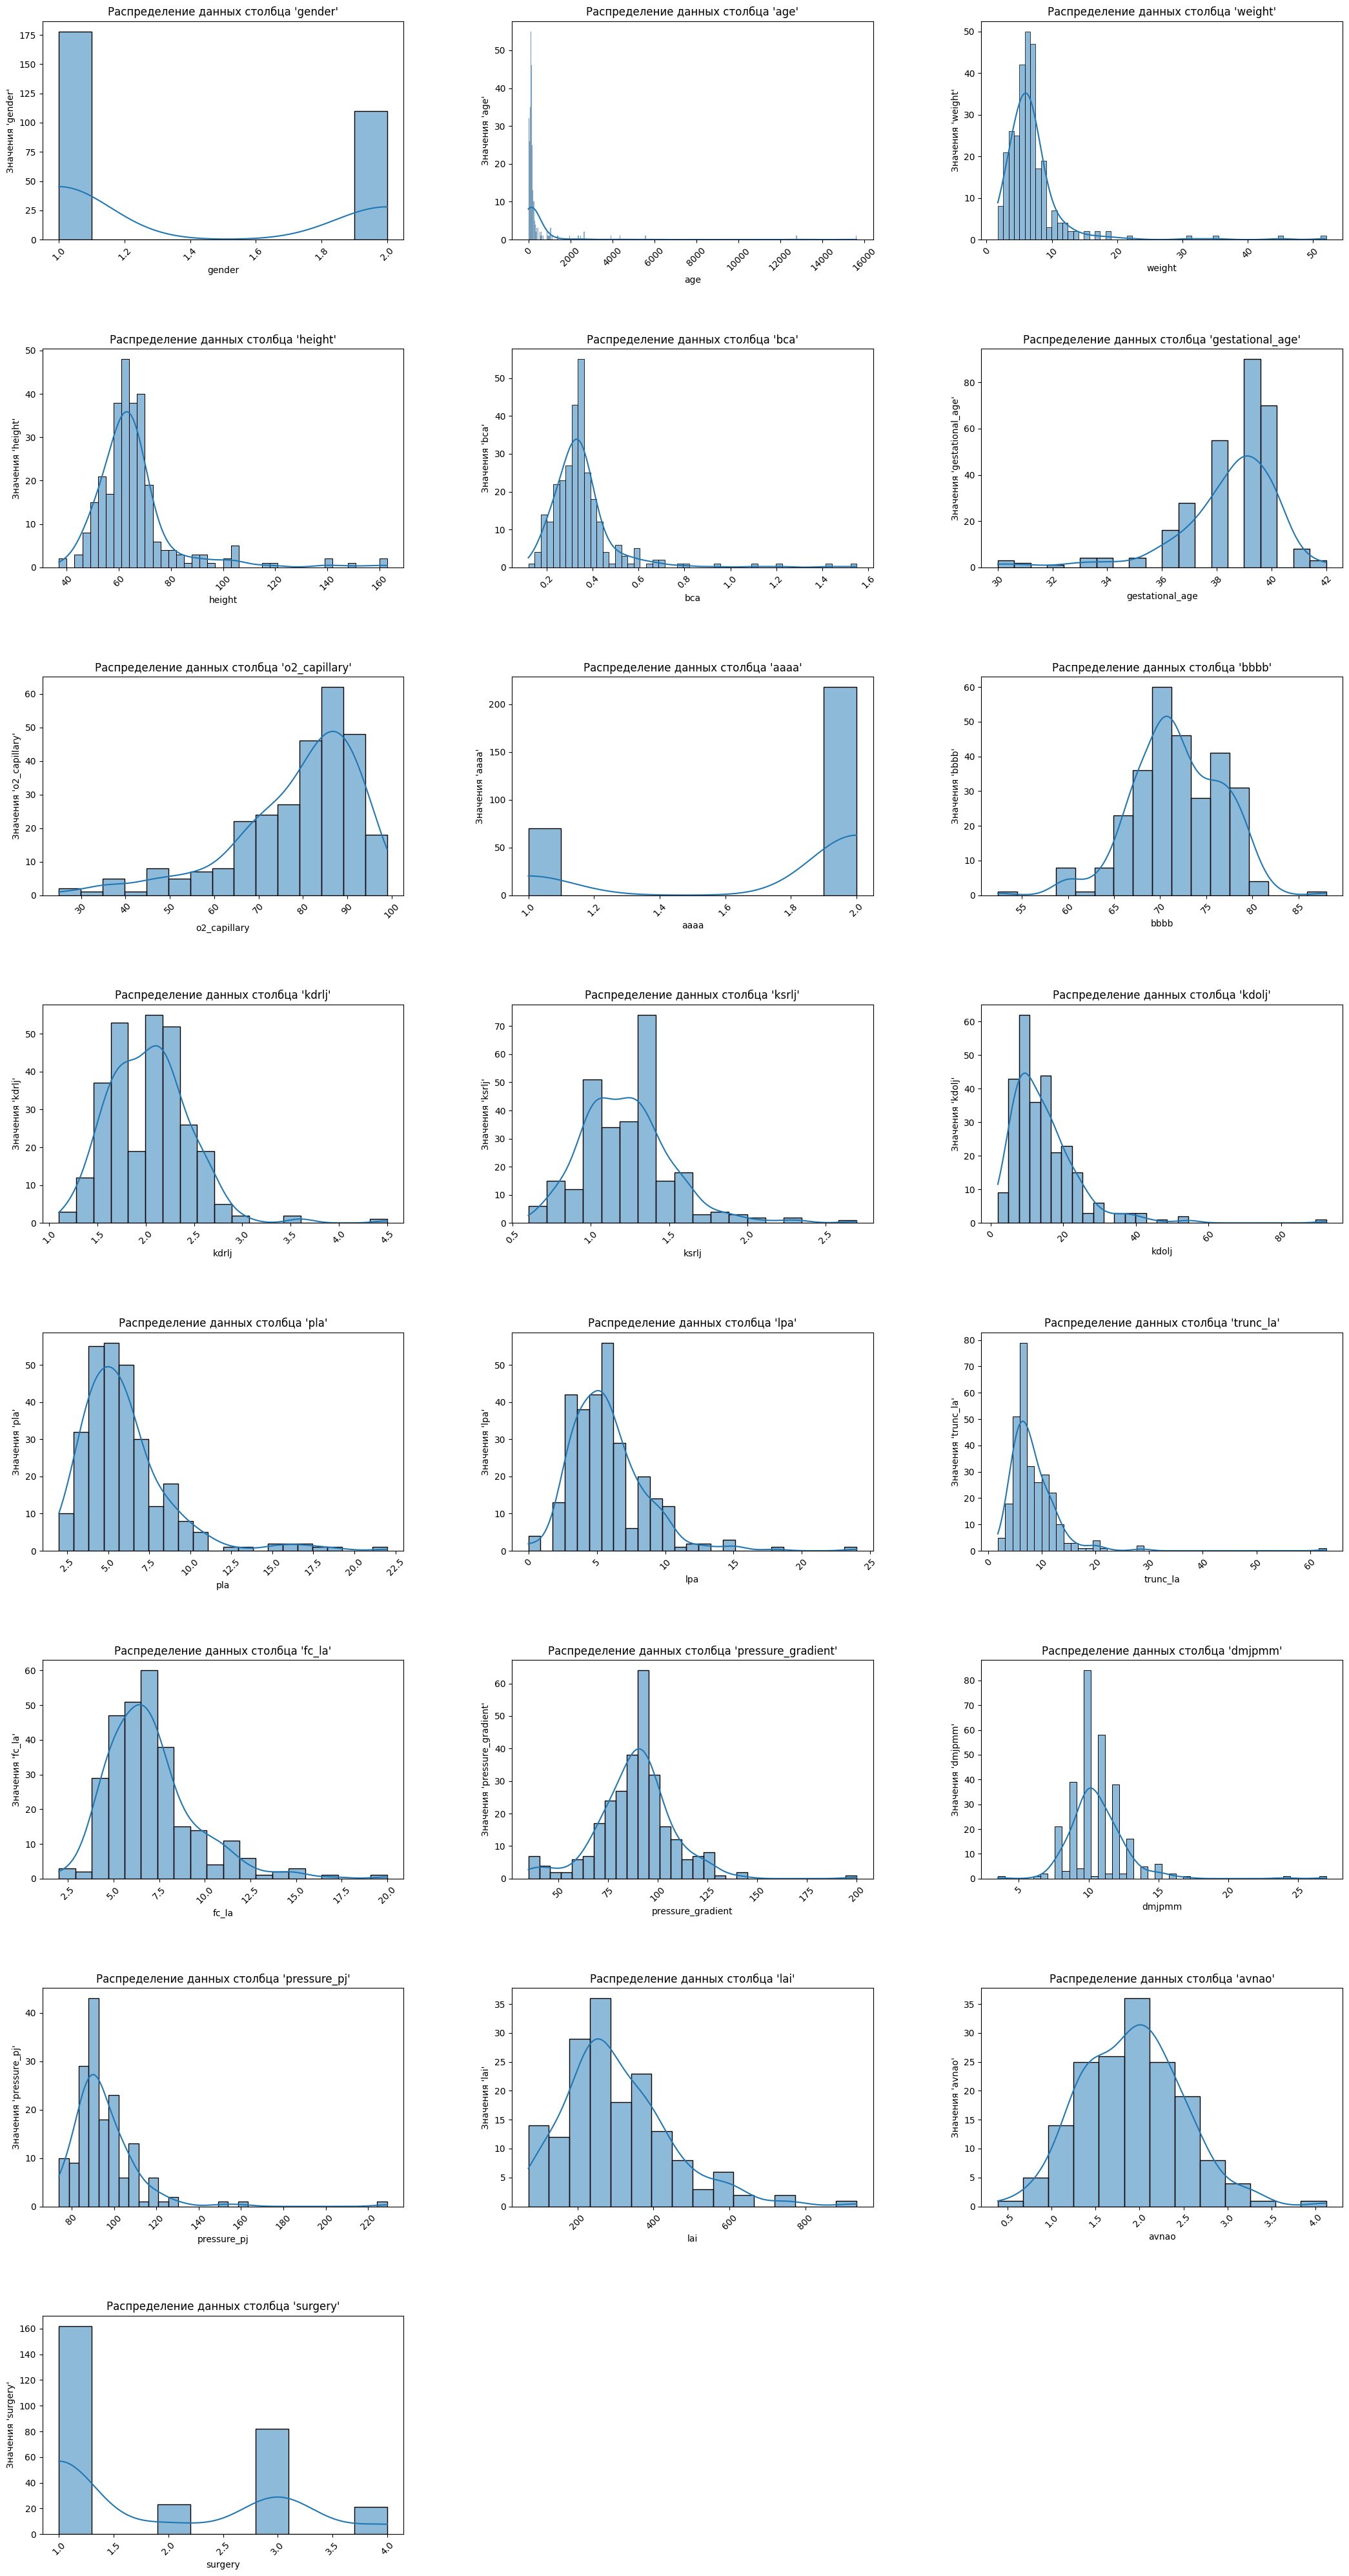

In [20]:
num_columns, cat_columns, num_df, cat_df  = divide_data_to_nums_and_cat_features(df)
plot_all_distributions(num_df)

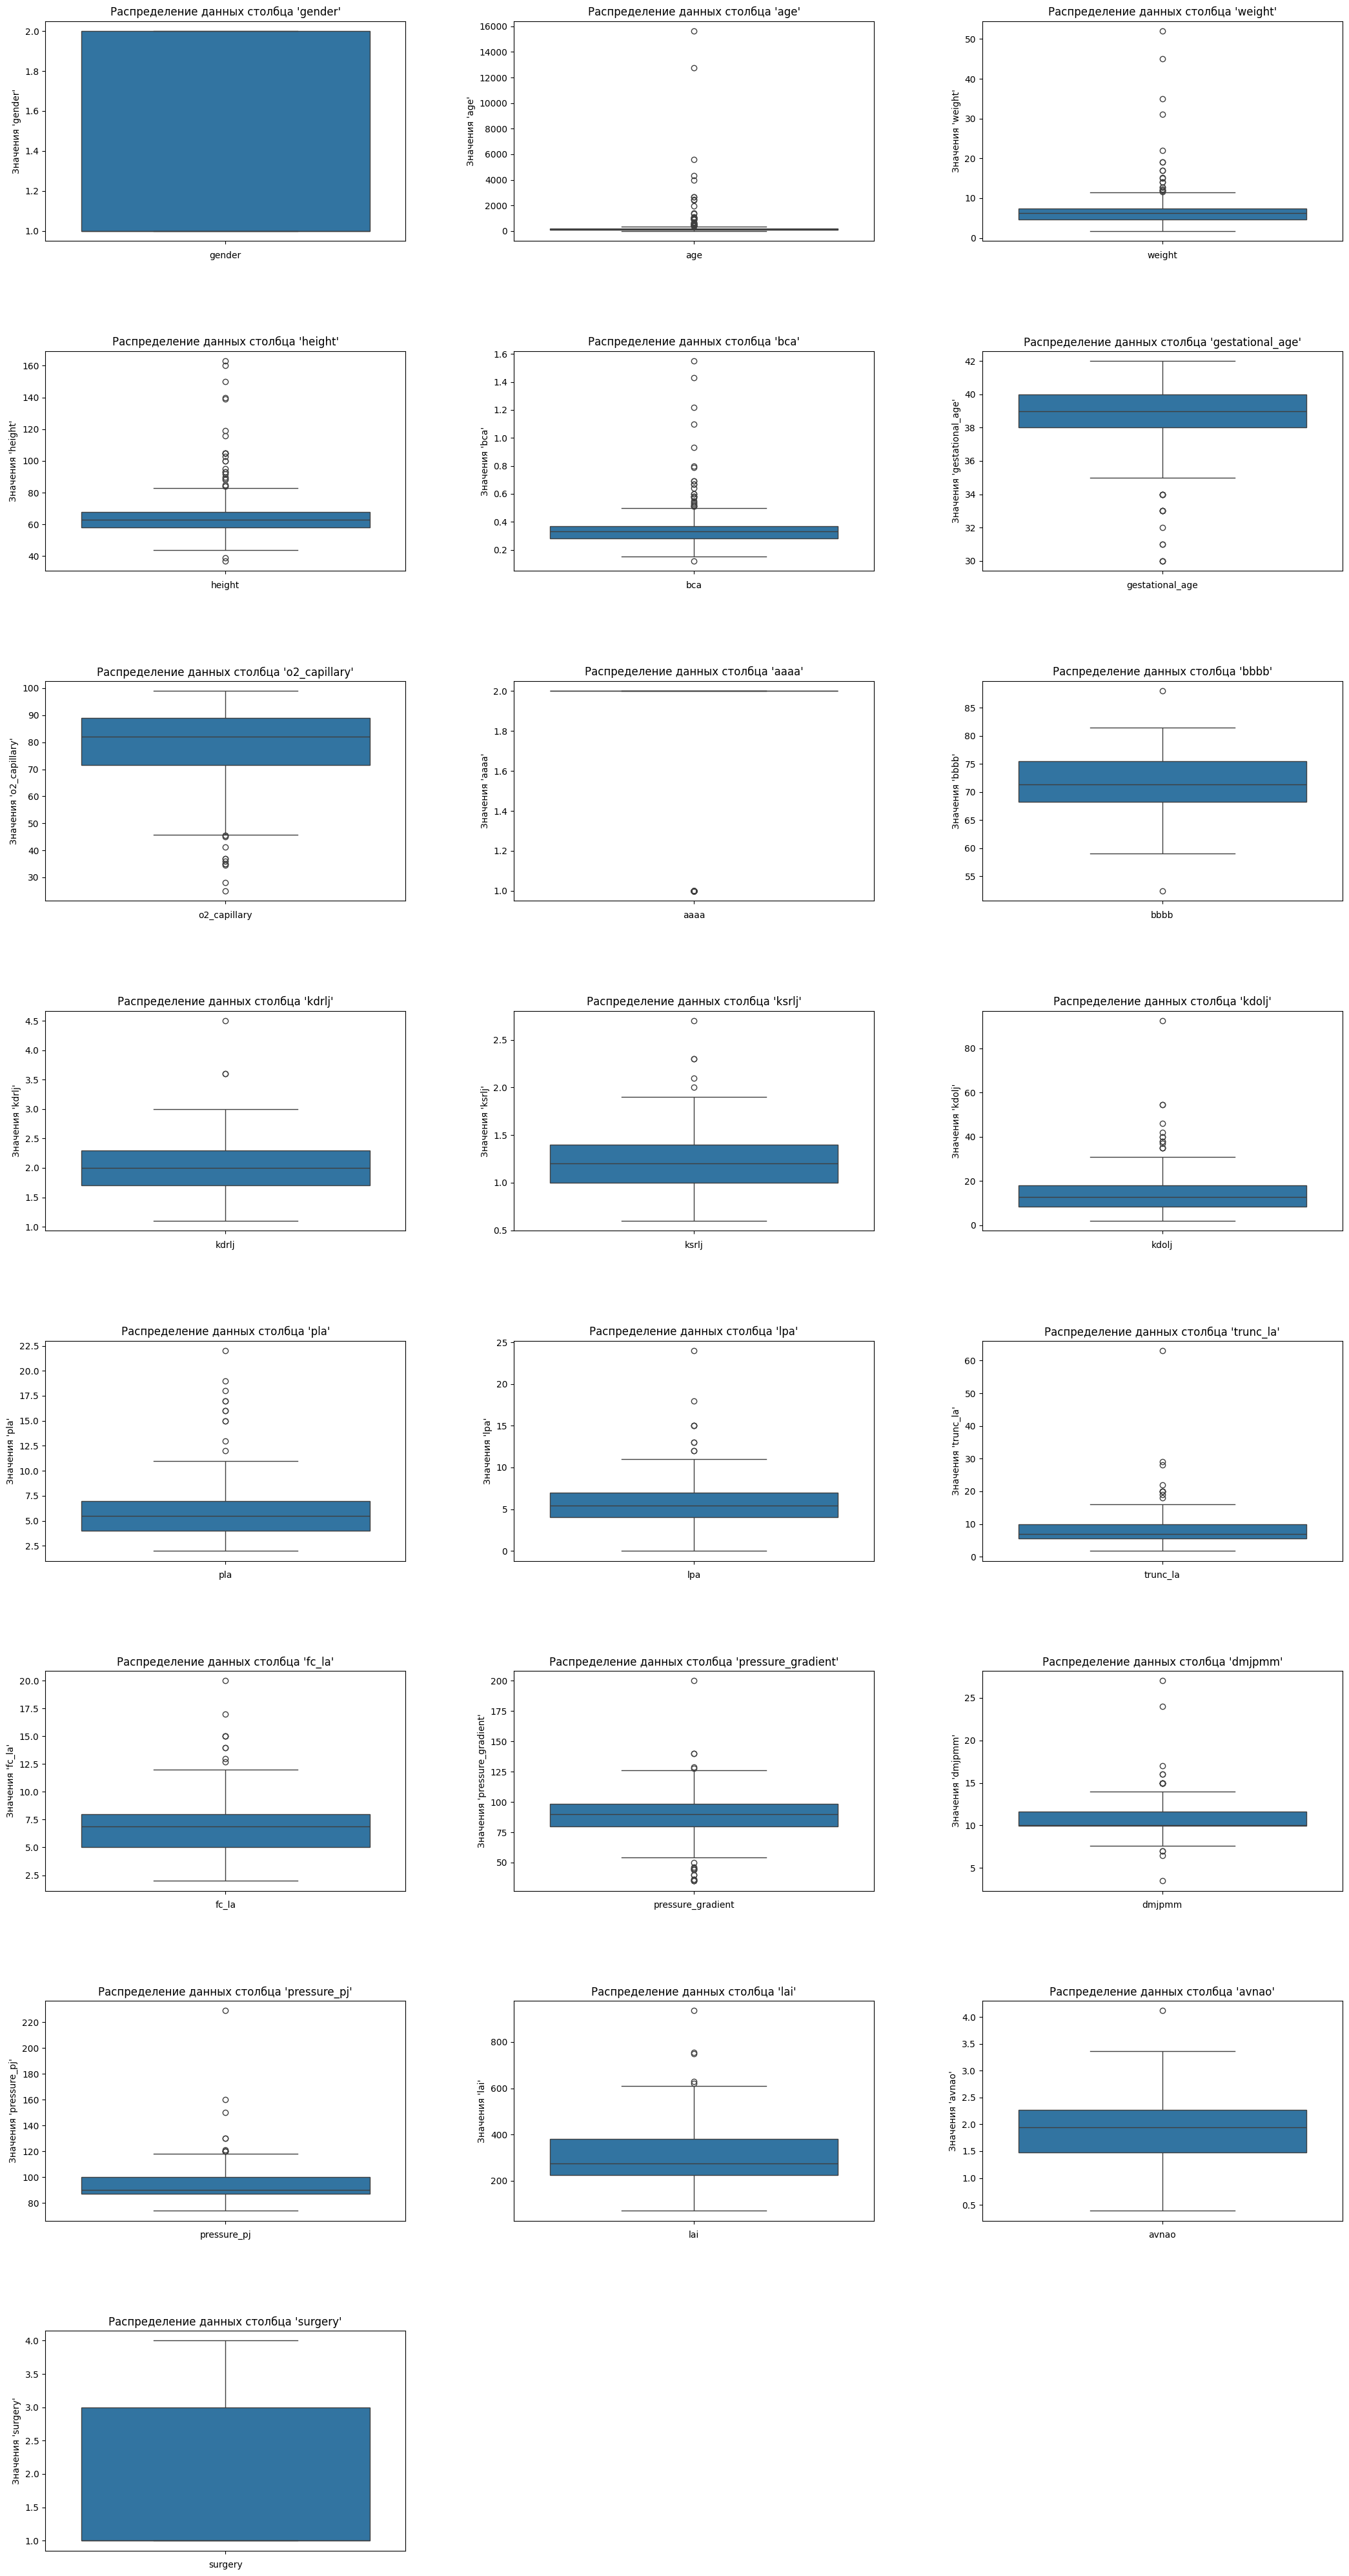

In [21]:
boxplot_all_distributions(num_df)

In [22]:
df.isnull().sum().sort_values(ascending=False)

pressure_pj          124
avnao                123
lai                  121
kdolj                 13
ksrlj                 12
pressure_gradient      5
o2_capillary           4
lpa                    2
kdrlj                  2
pla                    1
dmjpmm                 0
sashes_kl_la           0
fc_la                  0
trunc_la               0
gender                 0
age                    0
bbbb                   0
aaaa                   0
gestational_age        0
sopvps                 0
bca                    0
height                 0
weight                 0
surgery                0
dtype: int64

Корреляционный анализ

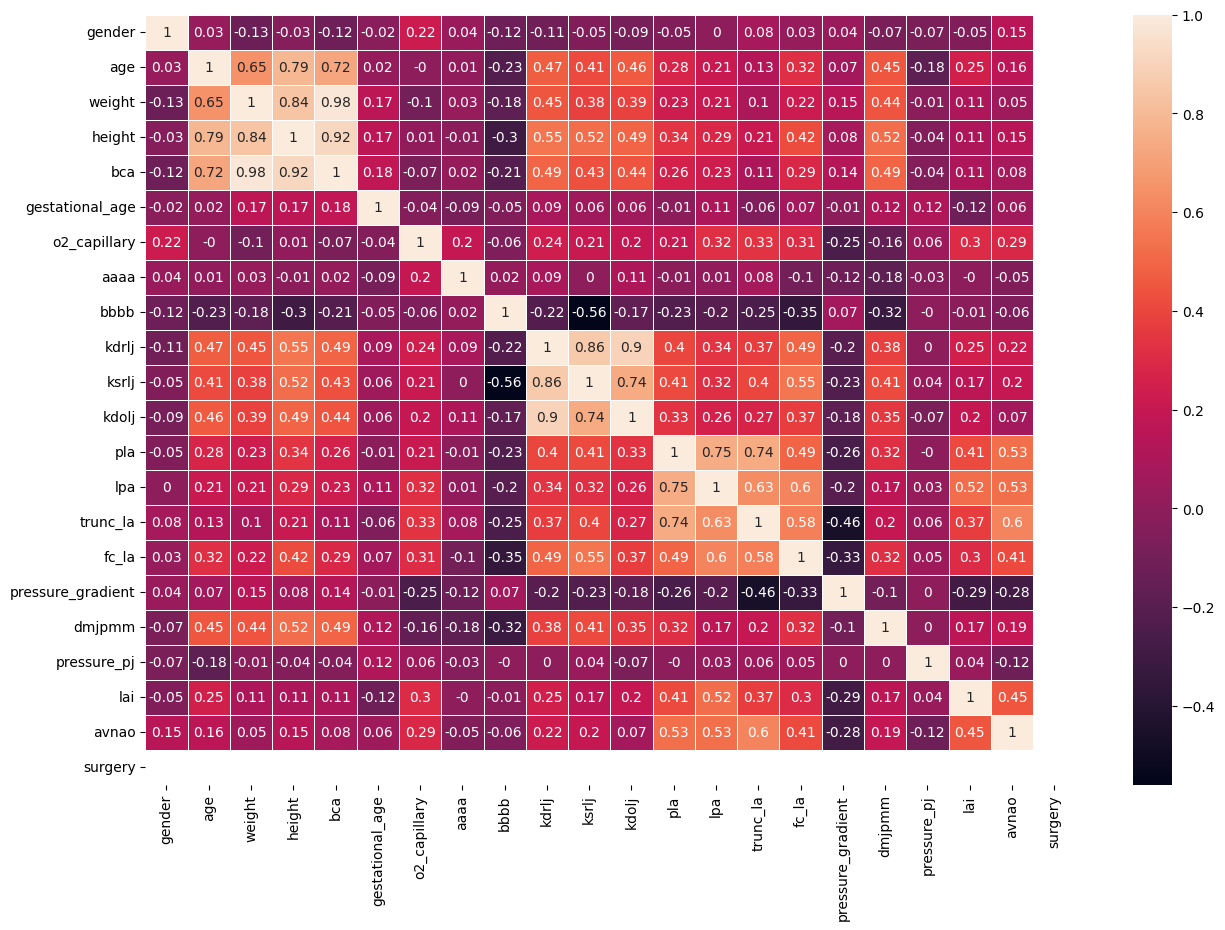

In [23]:
# построим матрицы корреляций для каждого из значений целевого признака
plt.figure(figsize = (15, 10))
sns.heatmap(df.loc[:, ~df.columns.isin(['sashes_kl_la', 'sopvps'])].query(
    'surgery == 1').corr(method='spearman').round(2), linewidths=.5, annot=True);

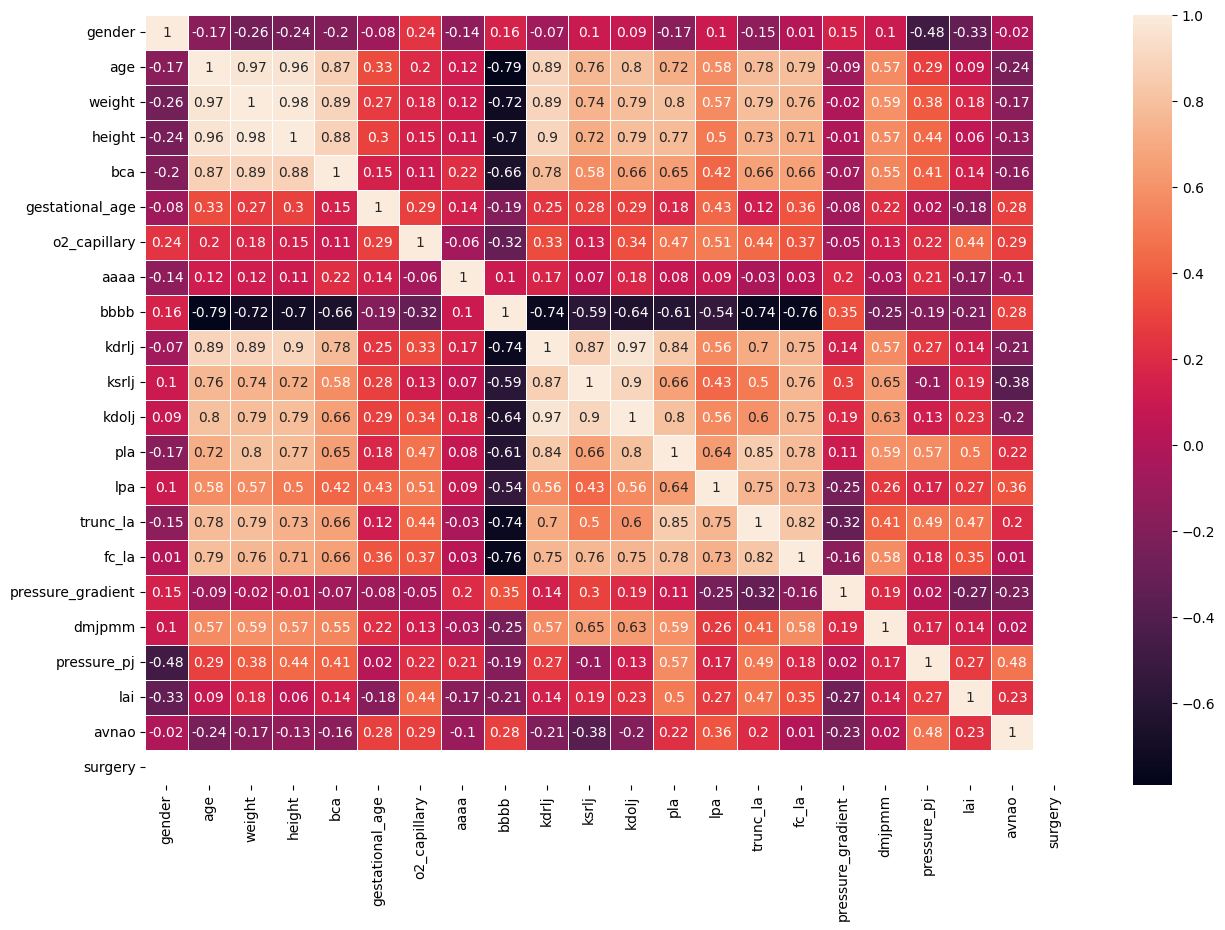

In [24]:
plt.figure(figsize = (15, 10))
sns.heatmap(df.loc[:, ~df.columns.isin(['sashes_kl_la', 'sopvps'])].query(
    'surgery == 2').corr(method='spearman').round(2), linewidths=.5, annot=True);

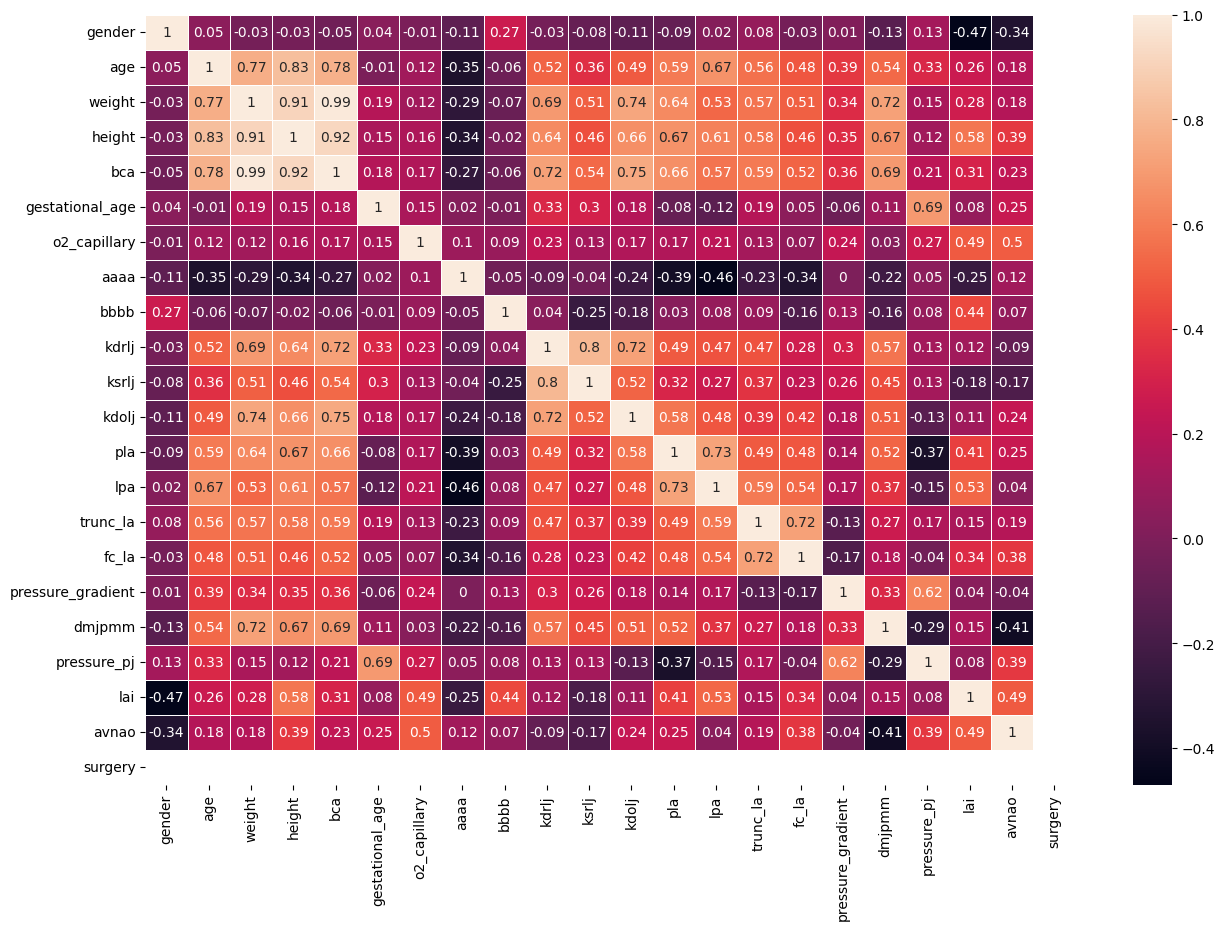

In [25]:
plt.figure(figsize = (15, 10))
sns.heatmap(df.loc[:, ~df.columns.isin(['sashes_kl_la', 'sopvps'])].query(
    'surgery == 3').corr(method='spearman').round(2), linewidths=.5, annot=True);

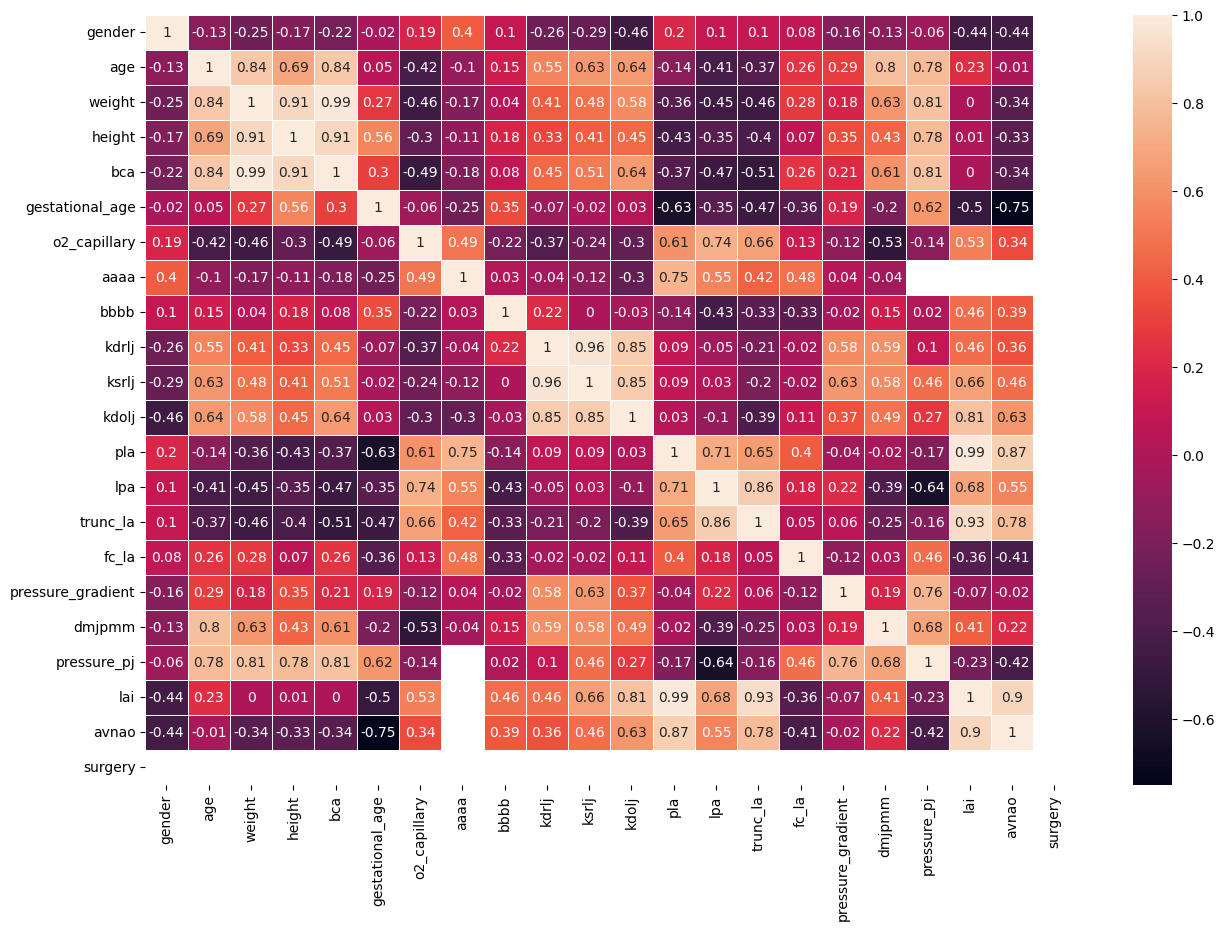

In [26]:
plt.figure(figsize = (15, 10))
sns.heatmap(df.loc[:, ~df.columns.isin(['sashes_kl_la', 'sopvps'])].query(
    'surgery == 4').corr(method='spearman').round(2), linewidths=.5, annot=True);

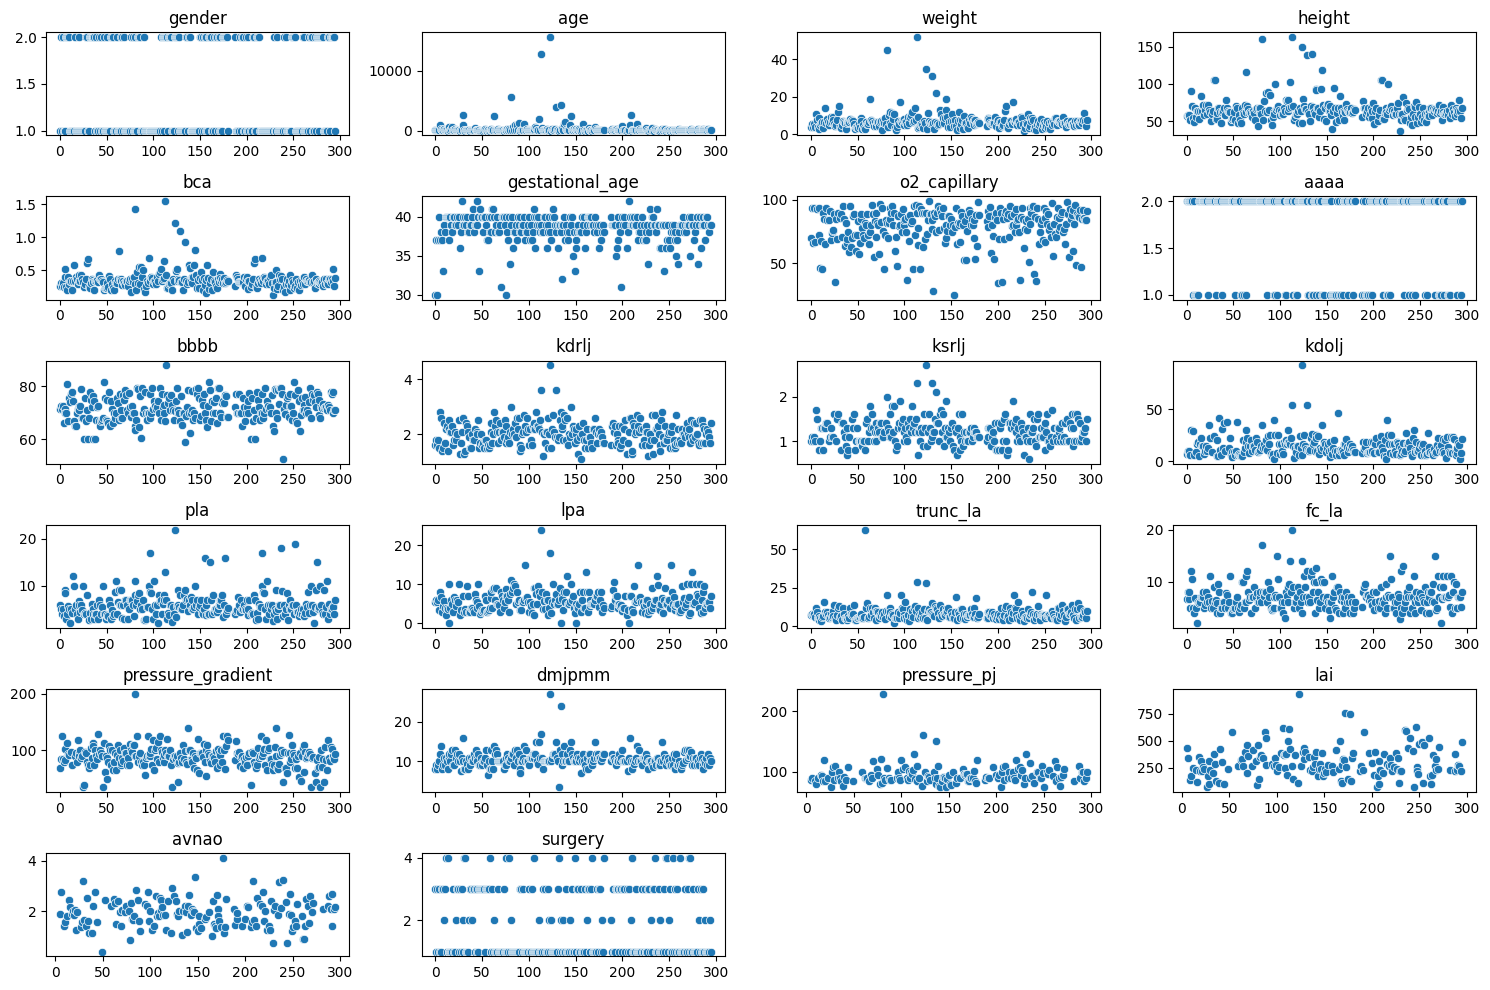

In [27]:
fig = plt.figure(figsize=(15,10))
for i, col in enumerate(df.loc[:, ~df.columns.isin(['sashes_kl_la', 'sopvps'])].columns):
    fig.add_subplot(6, 4, i+1)
    sns.scatterplot(df[col]).set_title(col)
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()

In [28]:
# Разделяем данные на train и test
X = df.drop('surgery', axis=1)
y = df['surgery']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE)

print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(201, 23)
(87, 23)
(201,)
(87,)


In [29]:
# заменим значения в целевом признаке на 0,1,2,3
y_train = y_train.apply(lambda x: x-1)
y_test = y_test.apply(lambda x: x-1)
print(y_train.unique(), y_test.unique())

[0 2 3 1] [0 2 3 1]


In [30]:
numeric_features = X_train.drop(columns=['sashes_kl_la', 'sopvps'], axis=1).columns
categorial_features = ['sashes_kl_la', 'sopvps']

X_train[numeric_features] = X_train[numeric_features].astype(float)
X_train[categorial_features] = X_train[categorial_features].astype(str)

# Предобработка числовых признаков
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median", missing_values=np.nan)),
           ("scaler", MinMaxScaler())
          ]
)

# Предобработка категориальных признаков
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='most_frequent')),
           ("encoder", OneHotEncoder(handle_unknown="ignore"))
          ]
)

# Преобразование признаков
data_preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorial_features)
    ])

In [31]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [

    # словарь для модели DecisionTreeClassifier
    {'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
     'models__max_depth': range(2,5),
     'models__max_features': range(2,5)
    },

    # словарь для модели LogisticRegression
    {'models': [LogisticRegression(
        random_state=RANDOM_STATE,
        solver='newton-cg',
        multi_class='multinomial')],
     'models__C': range(1,5)
    },

        # словарь для модели RandomForestClassifier
    {'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
     'models__n_estimators': range(50, 150),
     'models__max_depth': range(2,5),
     'models__min_samples_split': range(2,5)
    }
]


gs = GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    error_score='raise'
)
gs.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', gs.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', gs.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['gender', 'age', 'weight', 'height', 'bca', 'gestational_age',
       'o2_capillary', 'aaaa', 'bbbb', 'kdrlj', 'ksrlj', 'kdolj', 'pla', 'lpa',
       'trunc_la', 'fc_la', 'pressure_gradient', 'dmjpmm', 'pressure_pj',
       'lai', 'avnao'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImput

In [32]:
y_pred = gs.best_estimator_.predict(X_test)
print(f"Точность модали на тестовой выборке: {f1_score(y_test, y_pred, average='macro')}")

Точность модали на тестовой выборке: 0.4783118698213038


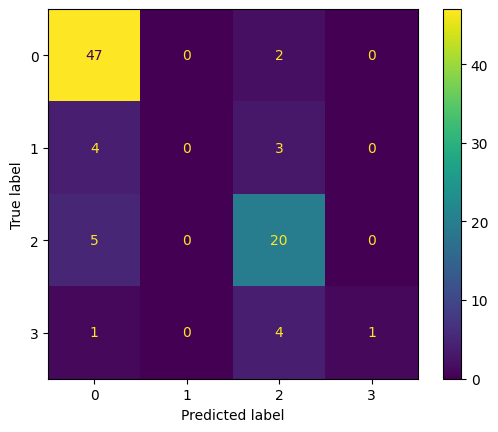

In [33]:
ConfusionMatrixDisplay.from_estimator(gs.best_estimator_, X_test, y_test)
plt.show() 

#### Вариант 2 (c imblearn)

In [34]:
s_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

numeric_transformer_imb = Pipeline(
    steps=[("scaler", StandardScaler()),
           ("imputer", SimpleImputer(strategy="median", missing_values=np.nan))
          ]
)

# Предобработка категориальных признаков
categorical_transformer_imb = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore")),
           ("imputer", SimpleImputer(strategy='most_frequent'))
          ]
)

# Преобразование признаков
data_preprocessor_imb = ColumnTransformer([
        ('num', numeric_transformer_imb, numeric_features),
        ('cat', categorical_transformer_imb, categorial_features)
    ],
    remainder='passthrough')

#### DecisionTreeClassifier

In [35]:
dt_pipeline = ImbPipeline([
    ('preprocessor', data_preprocessor_imb),
    ('oversampler', RandomOverSampler(random_state=RANDOM_STATE)),
    ('classifier', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

dt_params = {
    'classifier__min_samples_leaf': [2, 4, 6, 8],
    'classifier__max_depth': [4, 6, 8, 10, 12],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__min_samples_split': [2, 5, 10]
}

gs_dt = GridSearchCV(
    dt_pipeline,
    dt_params,
    cv=s_kfold,
    scoring='f1_macro',
    n_jobs=-1,
    error_score='raise'
)
gs_dt.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', gs_dt.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', gs_dt.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['gender', 'age', 'weight', 'height', 'bca', 'gestational_age',
       'o2_capillary', 'aaaa', 'bbbb', 'kdrlj', 'ksrlj', 'kdolj', 'pla', 'lpa',
       'trunc_la', 'fc_la', 'pressure_gradie...
       'lai', 'avnao'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                          

In [36]:
y_pred_dt = gs_dt.best_estimator_.predict(X_test)
print(f"Точность модали на тестовой выборке: {f1_score(y_test, y_pred_dt, average='macro')}")

Точность модали на тестовой выборке: 0.5620448179271708


#### RandomForestClassifier

In [37]:
rf_pipeline = ImbPipeline([
    ('preprocessor', data_preprocessor_imb),
    ('oversampler', RandomOverSampler(random_state=RANDOM_STATE)),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
])

rf_params = {
    'classifier__n_estimators': [25, 50, 75, 100],
    'classifier__min_samples_leaf': [2, 4, 6, 8],
    'classifier__max_depth': [6, 8, 10, 12],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__bootstrap': [True, False]
}

gs_rf = GridSearchCV(
    rf_pipeline,
    rf_params,
    cv=s_kfold,
    scoring='f1_macro',
    n_jobs=-1,
    error_score='raise'
)
gs_rf.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', gs_rf.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', gs_rf.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['gender', 'age', 'weight', 'height', 'bca', 'gestational_age',
       'o2_capillary', 'aaaa', 'bbbb', 'kdrlj', 'ksrlj', 'kdolj', 'pla', 'lpa',
       'trunc_la', 'fc_la', 'pressure_gradie...
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                       

In [38]:
y_pred_rf = gs_rf.best_estimator_.predict(X_test)
print(f"Точность модали на тестовой выборке: {f1_score(y_test, y_pred_rf, average='macro')}")

Точность модали на тестовой выборке: 0.7336691086691086


#### CatBoostClassifier

In [39]:
cb_pipeline = ImbPipeline([
    ('preprocessor', data_preprocessor_imb),
    ('oversampler', RandomOverSampler(random_state=RANDOM_STATE)),
    ('classifier', CatBoostClassifier(loss_function='MultiClass'))
])

cb_params = {
     'classifier__iterations': [25, 50, 150],  
     'classifier__learning_rate': [0.1, 0.3, 0.5],
     'classifier__depth': [6, 8, 10, 12] 
}

gs_cb = GridSearchCV(
    cb_pipeline,
    cb_params,
    cv=s_kfold,
    scoring='f1_macro',
    n_jobs=-1,
    error_score='raise'
)
gs_cb.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', gs_cb.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', gs_cb.best_score_)

0:	learn: 1.1553127	total: 154ms	remaining: 3.69s
1:	learn: 0.9288055	total: 158ms	remaining: 1.82s
2:	learn: 0.8160340	total: 162ms	remaining: 1.19s
3:	learn: 0.7179467	total: 166ms	remaining: 869ms
4:	learn: 0.6430251	total: 169ms	remaining: 676ms
5:	learn: 0.5777955	total: 173ms	remaining: 547ms
6:	learn: 0.5216703	total: 176ms	remaining: 453ms
7:	learn: 0.4704295	total: 180ms	remaining: 383ms
8:	learn: 0.4237456	total: 183ms	remaining: 326ms
9:	learn: 0.3935059	total: 186ms	remaining: 280ms
10:	learn: 0.3579013	total: 190ms	remaining: 241ms
11:	learn: 0.3443406	total: 192ms	remaining: 208ms
12:	learn: 0.3185189	total: 195ms	remaining: 180ms
13:	learn: 0.3029936	total: 198ms	remaining: 155ms
14:	learn: 0.2871544	total: 201ms	remaining: 134ms
15:	learn: 0.2639337	total: 204ms	remaining: 115ms
16:	learn: 0.2441923	total: 207ms	remaining: 97.4ms
17:	learn: 0.2341100	total: 210ms	remaining: 81.5ms
18:	learn: 0.2156351	total: 213ms	remaining: 67.2ms
19:	learn: 0.2060703	total: 215ms	rema

In [40]:
y_pred_cb = gs_cb.best_estimator_.predict(X_test)
print(f"Точность модали на тестовой выборке: {f1_score(y_test, y_pred_cb, average='macro')}")

Точность модали на тестовой выборке: 0.6799145299145299


#### LGBMClassifier

In [41]:
lgbm_pipeline = ImbPipeline([
    ('preprocessor', data_preprocessor_imb),
    ('oversampler', RandomOverSampler(random_state=RANDOM_STATE)),
    ('classifier', LGBMClassifier(random_state=RANDOM_STATE))
])

lgbm_params = {
     'classifier__learning_rate':[0.1, 0.03, 0.05],
     'classifier__num_leaves': [15, 20, 25, 30, 35],
     'classifier__max_depth': [2, 4, 6, 8, 10]
}

gs_lgbm = GridSearchCV(
    lgbm_pipeline,
    lgbm_params,
    cv=s_kfold,
    scoring='f1_macro',
    n_jobs=-1,
    error_score='raise'
)
gs_lgbm.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', gs_lgbm.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', gs_lgbm.best_score_)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 452, number of used features: 24
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

In [42]:
y_pred_lgbm = gs_lgbm.best_estimator_.predict(X_test)
print(f"Точность модали на тестовой выборке: {f1_score(y_test, y_pred_lgbm, average='macro')}")

Точность модали на тестовой выборке: 0.7708805031446541


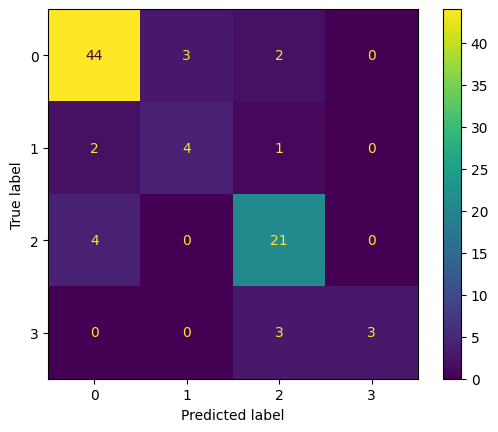

In [43]:
# получаем предсказания и строим матрицу ошибок
ConfusionMatrixDisplay.from_estimator(gs_rf.best_estimator_, X_test, y_test)
plt.show() 

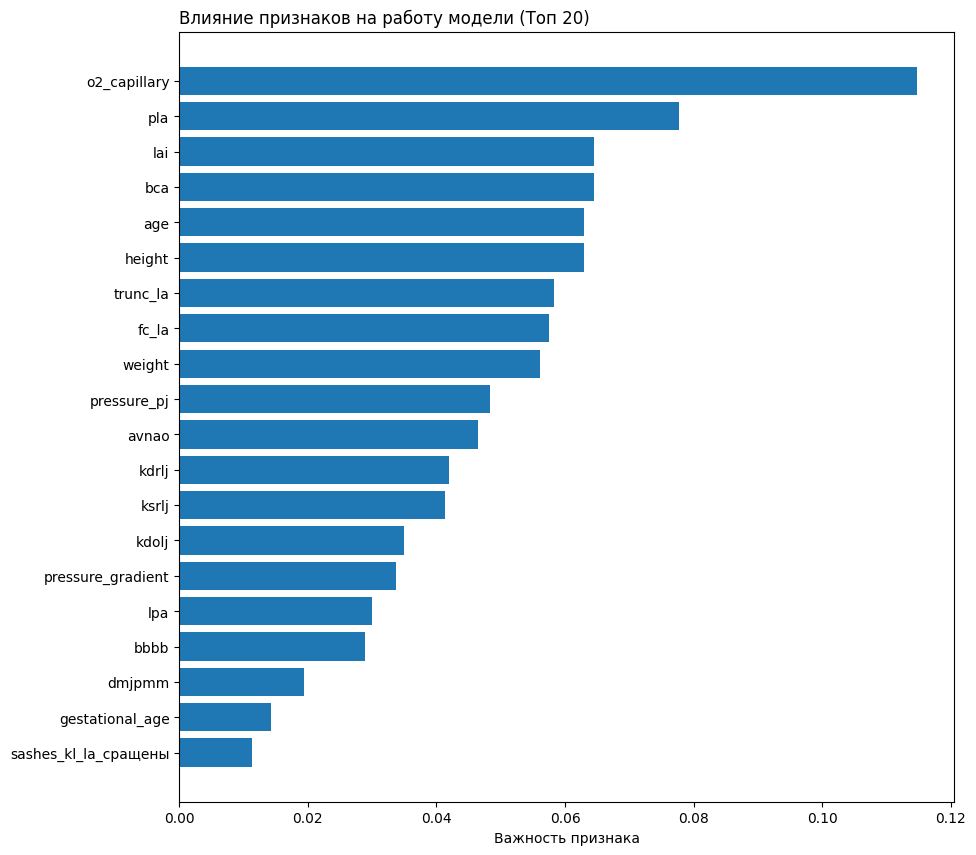

In [44]:
# Выводим график feature importance
column_names = gs_rf.best_estimator_.named_steps['preprocessor'].transformers_[1][1]\
                .get_feature_names_out(input_features=categorial_features)

feature_names = np.concatenate([numeric_features, column_names])

# Получение важности признаков из лучшего классификатора в пайплайне
importances = gs_rf.best_estimator_.named_steps['classifier'].feature_importances_

feature_importance(importances, feature_names)

#### Нейросеть

In [45]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.utils import to_categorical

In [46]:
X_train_processed = data_preprocessor.fit_transform(X_train)
X_test_processed = data_preprocessor.transform(X_test)
seq_model = Sequential()
seq_model.add(Dense(40, activation = 'relu'))
seq_model.add(Dense(40, activation = 'relu'))
seq_model.add(Dense(4, activation = 'softmax'))

In [47]:
seq_model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate= 1e-3), metrics = ['F1Score'])
seq_model.fit(X_train_processed, to_categorical(y_train.values), epochs = 30, batch_size = 5, validation_data=(X_test_processed, to_categorical(y_test.values)))
scores = seq_model.evaluate(X_test_processed, to_categorical(y_test.values))

for i, m in enumerate(seq_model.metrics_names):
    print(m, scores[i])

Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - F1Score: 0.1851 - loss: 1.3163 - val_F1Score: 0.1801 - val_loss: 1.0583
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - F1Score: 0.1930 - loss: 1.0566 - val_F1Score: 0.1801 - val_loss: 0.9914
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - F1Score: 0.1844 - loss: 0.9623 - val_F1Score: 0.2378 - val_loss: 0.9509
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - F1Score: 0.2210 - loss: 0.9537 - val_F1Score: 0.2944 - val_loss: 0.9113
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - F1Score: 0.3232 - loss: 0.9145 - val_F1Score: 0.3657 - val_loss: 0.8724
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - F1Score: 0.3283 - loss: 0.8601 - val_F1Score: 0.3717 - val_loss: 0.8499
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - F1Score: 0.3371 - loss: 0.7848 - val_F1Score: 0.3614 - val_loss: 0.8259
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - F1Score: 0.3623 - loss: 0.8570 - val_F1Score: 0.3598 - val_loss: 0.8113
Epoch 9

#### Нейросеть с oversampler 

In [48]:
rvs = RandomOverSampler(random_state=RANDOM_STATE)
X_train_processed_rvs, y_train_rvs = rvs.fit_resample(X_train_processed, y_train)

In [49]:
seq_model2 = Sequential()
seq_model2.add(Dense(10, activation = 'relu'))
seq_model2.add(Dense(20, activation = 'relu'))
seq_model2.add(Dense(30, activation = 'relu'))
seq_model2.add(Dropout(0.25))
seq_model2.add(Dense(4, activation = 'softmax'))
seq_model2.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate= 1e-3), metrics = ['F1Score'])

seq_model2.fit(X_train_processed_rvs, to_categorical(y_train_rvs.values), epochs = 30, batch_size = 5, validation_data=(X_test_processed, to_categorical(y_test.values)))
scores = seq_model2.evaluate(X_test_processed, to_categorical(y_test.values))

for i, m in enumerate(seq_model2.metrics_names):
    print(m, scores[i])

Epoch 1/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - F1Score: 0.1981 - loss: 1.4143 - val_F1Score: 0.3108 - val_loss: 1.3569
Epoch 2/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - F1Score: 0.3168 - loss: 1.3693 - val_F1Score: 0.2177 - val_loss: 1.3612
Epoch 3/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - F1Score: 0.3714 - loss: 1.3390 - val_F1Score: 0.1959 - val_loss: 1.3370
Epoch 4/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - F1Score: 0.3574 - loss: 1.3050 - val_F1Score: 0.2401 - val_loss: 1.3107
Epoch 5/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - F1Score: 0.4362 - loss: 1.2269 - val_F1Score: 0.2313 - val_loss: 1.3190
Epoch 6/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - F1Score: 0.4142 - loss: 1.1723 - val_F1Score: 0.3616 - val_loss: 1.2458
Epoch 7/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - F1Score: 0.4868 - loss: 1.1023 - val_F1Score: 0.3859 - val_loss: 1.2965
Epoch 8/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - F1Score: 0.4885 - loss: 1.0705 - val_F1Score: 0.4276 - val_loss: 1.1810
Epoch 9/

#### Генерация новых признаков

In [50]:
df_fg = df.copy()

df_fg['cavi'] = df_fg['ksrlj'] / df_fg['kdolj'] # индекс жесткости сосудов 
df_fg['olrf'] = df_fg['o2_capillary'] / df_fg['aaaa'] # уровень кислорода при дыхательной недостаточности 
df_fg['papi'] = df_fg['pressure_gradient'] / df['pressure_pj'] # Индекс давления в легочной артерии
df_fg['weight_age_ratio'] = df_fg['weight'] / df_fg['age'] # Соотношение веса к возрасту 
df_fg['heart_rate_index'] = df_fg['fc_la'] / df_fg['age'] # Индекс сердечного ритма 
df_fg['aaaa_age_ratio'] = df_fg['aaaa'] / df_fg['age'] # Соотношение УЛК к возрасту 

In [51]:
num_columns_fg, cat_columns_fg, num_df_fg, cat_df_fg  = divide_data_to_nums_and_cat_features(df_fg)

In [52]:
# Разделяем данные на train и test
W = df_fg.drop('surgery', axis=1)
z = df_fg['surgery']

W_train, W_test, z_train, z_test = train_test_split(W, z, test_size=TEST_SIZE, stratify=z, random_state=RANDOM_STATE)

print(W_train.shape)
print(W_test.shape)

print(z_train.shape)
print(z_test.shape)

(201, 29)
(87, 29)
(201,)
(87,)


In [53]:
df_fg['surgery'].unique()

array([3, 1, 2, 4], dtype=int64)

In [54]:
# заменим значения в целевом признаке на 0,1,2,3
z_train = z_train.apply(lambda x: x-1)
z_test = z_test.apply(lambda x: x-1)
print(z_train.unique(), z_test.unique())

[0 2 3 1] [0 2 3 1]


In [55]:
numeric_features_new = W_train.drop(columns=['sashes_kl_la', 'sopvps'], axis=1).columns
categorial_features_new = ['sashes_kl_la', 'sopvps']

W_train[numeric_features_new] = W_train[numeric_features_new].astype(float)
W_train[categorial_features_new] = W_train[categorial_features_new].astype(str)

new_numeric_transformer_imb = Pipeline(
    steps=[("scaler", StandardScaler()),
           ("imputer", SimpleImputer(strategy="median", missing_values=np.nan))
          ]
)

# Предобработка категориальных признаков
new_categorical_transformer_imb = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore")),
           ("imputer", SimpleImputer(strategy='most_frequent'))
          ]
)

# Преобразование признаков
new_data_preprocessor_imb = ColumnTransformer([
        ('num', new_numeric_transformer_imb, numeric_features_new),
        ('cat', new_categorical_transformer_imb, categorial_features_new)
    ],
    remainder='passthrough')

In [56]:
rf_pipeline_new = ImbPipeline([
    ('preprocessor', new_data_preprocessor_imb),
    ('oversampler', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
])

rf_params = {
    'classifier__n_estimators': [25, 50, 75, 100],
    'classifier__min_samples_leaf': [2, 4, 6, 8],
    'classifier__max_depth': [6, 8, 10, 12],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__bootstrap': [True, False]
}

gs_rf_new = GridSearchCV(
    rf_pipeline_new,
    rf_params,
    cv=s_kfold,
    scoring='f1_macro',
    n_jobs=-1,
    error_score='raise'
)
gs_rf_new.fit(W_train, z_train)

print('Лучшая модель и её параметры:\n\n', gs_rf_new.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', gs_rf_new.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['gender', 'age', 'weight', 'height', 'bca', 'gestational_age',
       'o2_capillary', 'aaaa', 'bbbb', 'kdrlj', 'ksrlj', 'kdolj', 'pla', 'lpa',
       'trunc_la', 'fc_la', 'pressure_gradie...
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                       

In [57]:
z_pred_rf = gs_rf_new.best_estimator_.predict(W_test)
print(f"Точность модали на тестовой выборке: {f1_score(z_test, z_pred_rf, average='macro')}")

Точность модали на тестовой выборке: 0.769270015698587


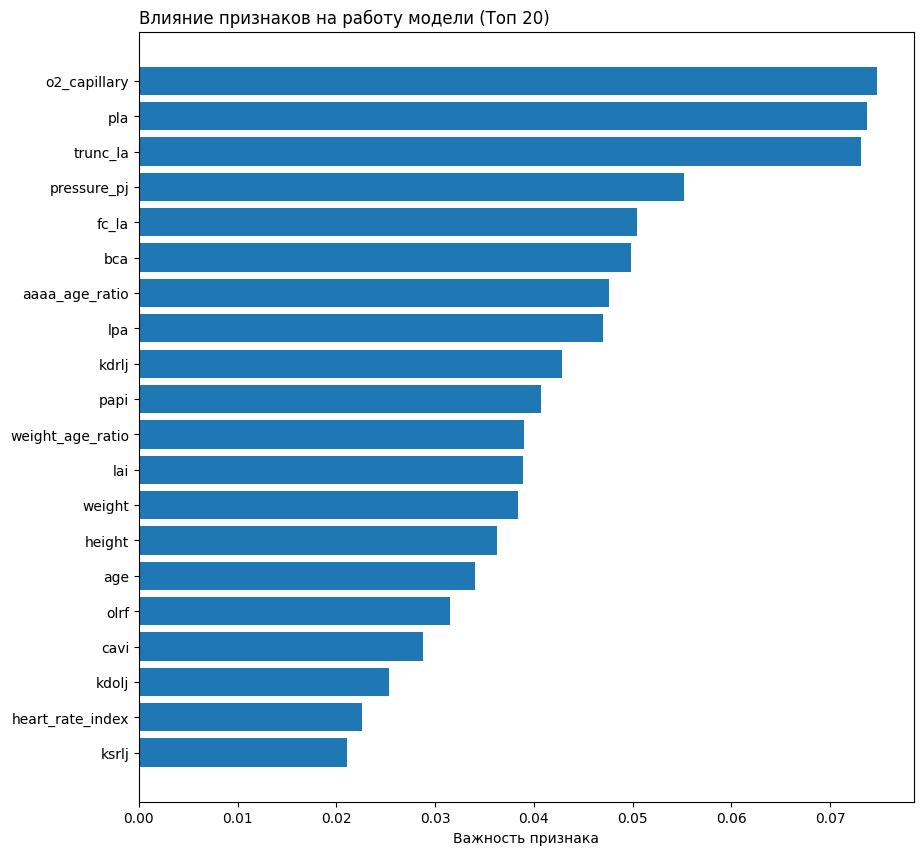

In [58]:
# Выводим график feature importance
column_names_new = gs_rf_new.best_estimator_.named_steps['preprocessor'].transformers_[1][1]\
                .get_feature_names_out(input_features=categorial_features_new)

feature_names_new = np.concatenate([numeric_features_new, column_names_new])

# Получение важности признаков из лучшего классификатора в пайплайне
importances_new = gs_rf_new.best_estimator_.named_steps['classifier'].feature_importances_

feature_importance(importances_new, feature_names_new)

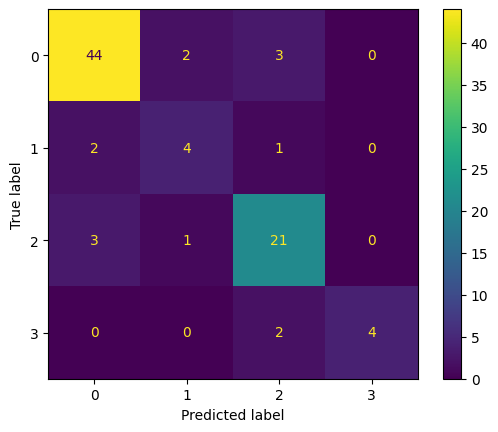

In [59]:
# получаем предсказания и строим матрицу ошибок
ConfusionMatrixDisplay.from_estimator(gs_rf_new.best_estimator_, W_test, z_test)
plt.show() 

#### Нейросеть с новыми признаками

In [60]:
W_train_processed = new_data_preprocessor_imb.fit_transform(W_train)
W_test_processed = new_data_preprocessor_imb.transform(W_test)

rvs2 = RandomOverSampler(random_state=RANDOM_STATE)
W_train_processed_rvs, z_train_rvs = rvs2.fit_resample(W_train_processed, z_train)

seq_model3 = Sequential()
seq_model3.add(Dense(10, activation = 'relu'))
seq_model3.add(Dropout(0.15))
seq_model3.add(Dense(20, activation = 'relu'))
seq_model3.add(Dropout(0.15))
seq_model3.add(Dense(30, activation = 'relu'))
seq_model3.add(Dropout(0.15))
seq_model3.add(Dense(4, activation = 'softmax'))
seq_model3.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate= 1e-3), metrics = ['F1Score'])

seq_model3.fit(W_train_processed_rvs, to_categorical(z_train_rvs.values), epochs = 30, batch_size = 5, validation_data=(W_test_processed, to_categorical(z_test.values)))
scores3 = seq_model3.evaluate(W_test_processed, to_categorical(z_test.values))

for i, m in enumerate(seq_model3.metrics_names):
    print(m, scores3[i])

Epoch 1/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - F1Score: 0.2515 - loss: 1.3692 - val_F1Score: 0.1975 - val_loss: 1.3562
Epoch 2/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - F1Score: 0.3715 - loss: 1.2902 - val_F1Score: 0.2941 - val_loss: 1.3134
Epoch 3/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - F1Score: 0.4734 - loss: 1.1924 - val_F1Score: 0.4033 - val_loss: 1.1903
Epoch 4/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - F1Score: 0.6098 - loss: 1.0548 - val_F1Score: 0.4920 - val_loss: 1.0153
Epoch 5/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - F1Score: 0.6102 - loss: 1.0024 - val_F1Score: 0.4661 - val_loss: 0.9605
Epoch 6/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - F1Score: 0.6318 - loss: 0.8685 - val_F1Score: 0.5378 - val_loss: 0.9333
Epoch 7/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - F1Score: 0.6642 - loss: 0.8277 - val_F1Score: 0.5870 - val_loss: 0.9298
Epoch 8/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - F1Score: 0.6755 - loss: 0.7986 - val_F1Score: 0.5821 - val_loss: 0.9180
Epoch 9/

In [61]:
neu_preds = seq_model3.predict(W_test_processed)
neu_preds.shape

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


(87, 4)

In [62]:
neu_preds_cls = neu_preds.argmax(axis=1)
neu_preds_cls

array([0, 0, 0, 3, 3, 0, 1, 0, 2, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 2, 0,
       2, 0, 3, 3, 3, 1, 3, 2, 2, 0, 0, 1, 0, 0, 0, 3, 0, 0, 2, 2, 0, 0,
       0, 0, 1, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 2, 2,
       0, 1, 1, 0, 2, 2, 0, 3, 0, 0, 2, 0, 2, 0, 2, 0, 1, 0, 0, 0, 3],
      dtype=int64)

In [63]:
print(f'Точность нейросети на тестовой выборке:\n{f1_score(z_test, neu_preds_cls, average="macro")}')

Точность нейросети на тестовой выборке:
0.6283431897493275


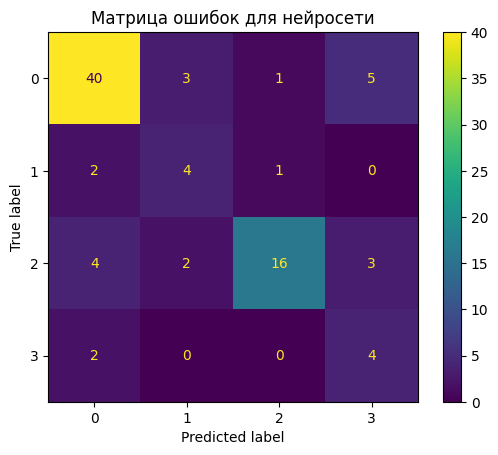

In [64]:
cm = confusion_matrix(z_test, neu_preds_cls)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot();
plt.title('Матрица ошибок для нейросети');

#### Результаты лучших моделей

In [65]:
print(f'Точность модели RF на тренировочной выборке:\n{gs_rf.best_score_}\n Лучшие гиперпараметры:\n{gs_rf.best_params_}')
print(f"Точность модели RF на тестовой выборке:\n{f1_score(y_test, y_pred_rf, average='macro')}")
print()
print()
print(f'Точность модели RF с новыми признаками на тренировочной выборке:\n{gs_rf_new.best_score_}\n Лучшие гиперпараметры:\n{gs_rf_new.best_params_}')
print(f"Точность RF c новыми признаками на тестовой выборке:\n{f1_score(z_test, z_pred_rf, average='macro')}")
print()
print()
print(f'Точность нейросети на тестовой выборке:\n{f1_score(z_test, neu_preds_cls, average="macro")}')

Точность модели RF на тренировочной выборке:
0.7467410326337246
 Лучшие гиперпараметры:
{'classifier__bootstrap': False, 'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 50}
Точность модели RF на тестовой выборке:
0.7336691086691086


Точность модели RF с новыми признаками на тренировочной выборке:
0.7233540572902275
 Лучшие гиперпараметры:
{'classifier__bootstrap': False, 'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 25}
Точность RF c новыми признаками на тестовой выборке:
0.769270015698587


Точность нейросети на тестовой выборке:
0.6283431897493275
